In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import umap
import matplotlib.pyplot as plt
import os
import gc
from tqdm import tqdm

# 设置中文字体
import matplotlib
import matplotlib.pyplot as plt

# 自动检测可用的中文字体
from matplotlib.font_manager import FontProperties
import random
import os
from tqdm import tqdm

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 创建保存目录
save_dir = '/exp_data/sjx/star/experiments/zhongjianceng_umap/ceng_results/'
os.makedirs(save_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


In [2]:
print(f"使用设备: {device}")


class ProteinNPYDataset(Dataset):
    def __init__(self, pos_path, neg_path):
        self.pos = np.load(pos_path, mmap_mode='r')
        self.neg = np.load(neg_path, mmap_mode='r')
        self.lengths = [len(self.pos), len(self.neg)]
        self.total_len = self.lengths[0] + self.lengths[1]

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        if idx < self.lengths[0]:
            x = self.pos[idx]
            y = 1
        else:
            x = self.neg[idx - self.lengths[0]]
            y = 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

使用设备: cuda


In [3]:
class MLPExperts(nn.Module):
    def __init__(self, d_model, d_ff, num_experts):
        super().__init__()
        self.num_experts = num_experts
        self.fc1 = nn.Linear(d_model, d_ff * num_experts, bias=True)
        self.fc2 = nn.Linear(d_ff, d_model, bias=True)
        self.d_ff = d_ff
        
    def forward(self, x, expert_idx):
        all_hidden = self.fc1(x)
        all_hidden = all_hidden.view(x.size(0), self.num_experts, self.d_ff)
        out = []
        for i in range(expert_idx.size(1)):
            idx = expert_idx[:, i]
            hidden = all_hidden[torch.arange(x.size(0)), idx]
            hidden = F.gelu(hidden)
            out_i = self.fc2(hidden)
            out.append(out_i)
        out = torch.stack(out, dim=1)
        return out

class NoisyTopKMoE(nn.Module):
    def __init__(self, d_model, d_ff, num_experts=30, k=2, noisy_std=1.0):
        super().__init__()
        self.num_experts = num_experts
        self.k = k
        self.noisy_std = noisy_std
        self.experts = MLPExperts(d_model, d_ff, num_experts)
        self.gate = nn.Linear(d_model, num_experts)
        
    def forward(self, x):
        B, L, D = x.shape
        x_flat = x.reshape(-1, D)
        gate_logits = self.gate(x_flat)
        if self.training and self.noisy_std > 0:
            noise = torch.randn_like(gate_logits) * self.noisy_std
            gate_logits = gate_logits + noise
        gate_scores = F.softmax(gate_logits, dim=-1)
        topk_val, topk_idx = torch.topk(gate_scores, self.k, dim=-1)
        meangate = gate_scores.mean(dim=0)
        load_balance_loss = (meangate * meangate).sum() * (self.num_experts ** 2)
        expert_outs = self.experts(x_flat, topk_idx)
        topk_val = topk_val / (topk_val.sum(dim=-1, keepdim=True) + 1e-9)
        moe_out = (expert_outs * topk_val.unsqueeze(-1)).sum(dim=1)
        moe_out = moe_out.view(B, L, D)
        return moe_out, load_balance_loss

class TransformerMoEBlock(nn.Module):
    def __init__(self, d_model, nhead, d_ff, num_experts=30, k=2, dropout=0.1, noisy_std=1.0):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.moe = NoisyTopKMoE(d_model, d_ff, num_experts, k, noisy_std)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        attn_out, _ = self.self_attn(x, x, x)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        moe_out, load_balance_loss = self.moe(x)
        x = x + self.dropout(moe_out)
        x = self.norm2(x)
        return x, load_balance_loss

class TransformerMoE(nn.Module):
    def __init__(self, d_model=1152, nhead=8, d_ff=2048, num_layers=4, num_experts=30, k=3, dropout=0.1, noisy_std=1.0, num_classes=2):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerMoEBlock(d_model, nhead, d_ff, num_experts, k, dropout, noisy_std)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )
        
    def forward(self, x):
        total_load_balance_loss = 0
        for layer in self.layers:
            x, lb_loss = layer(x)
            total_load_balance_loss += lb_loss
        x = x.mean(dim=1)
        logits = self.classifier(x)
        return logits, total_load_balance_loss

In [4]:
class LayerOutputHook:
    def __init__(self):
        self.layer_outputs = []
        self.hooks = []
        
    def register_hooks(self, model):
        """为模型注册hooks，不修改原始模型"""
        self.clear_hooks()
        
        # 为每层注册hook
        for i, layer in enumerate(model.layers):
            def make_hook(layer_idx):
                def hook(module, input, output):
                    # output是(x, load_balance_loss)的元组
                    layer_output = output[0].detach().cpu()  # 只取x，不要loss
                    self.layer_outputs.append(layer_output)
                return hook
            
            hook = layer.register_forward_hook(make_hook(i))
            self.hooks.append(hook)
    
    def clear_hooks(self):
        """清除所有hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.layer_outputs = []
    
    def get_outputs(self):
        """获取当前batch的层输出"""
        outputs = self.layer_outputs.copy()
        self.layer_outputs = []  # 清空，为下一个batch准备
        return outputs

In [5]:
# 加载原始模型（不修改架构）
model = TransformerMoE(
    d_model=1152, nhead=8, d_ff=2048, num_layers=4, num_experts=30, k=3, 
    dropout=0.1, noisy_std=1.0, num_classes=2
).to(device)

# 加载权重
weight_path = '/exp_data/sjx/star/main_transformer_moe_weight/best_transformer_moe_last.pth'
model.load_state_dict(torch.load(weight_path, map_location=device))
model.eval()

# 创建hook管理器
hook_manager = LayerOutputHook()

# 加载测试数据
test_pos = '/exp_data/sjx/star/first_data/ESM-embedding/positive_test_embedding.npy'
test_neg = '/exp_data/sjx/star/first_data/ESM-embedding/negative_test_embedding.npy'
test_dataset = ProteinNPYDataset(test_pos, test_neg)

# 使用小batch_size减少内存占用
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

print(f"模型加载完成")
print(f"测试集大小: {len(test_dataset)}")
print(f"正样本: {len(test_dataset.pos)}, 负样本: {len(test_dataset.neg)}")

/tmp/ipykernel_1265995/2351576554.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path, map_location=device))


模型加载完成
测试集大小: 1149
正样本: 818, 负样本: 331


In [6]:
# 注册hooks
hook_manager.register_hooks(model)

# 提取每层输出
all_layer_outputs = [[] for _ in range(5)]  # 0: 原始输入, 1-4: 4层输出
all_labels = []

print("开始提取每层输出...")
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(test_loader, desc="提取层输出")):
        x, y = x.to(device), y.to(device)
        
        # 保存原始输入（第0层）
        all_layer_outputs[0].append(x.cpu().numpy())
        
        # 前向传播，hooks会自动捕获每层输出
        _ = model(x)
        
        # 获取当前batch的层输出
        batch_layer_outputs = hook_manager.get_outputs()
        
        # 保存每层输出
        for layer_idx, layer_output in enumerate(batch_layer_outputs):
            all_layer_outputs[layer_idx + 1].append(layer_output.numpy())
        
        # 保存标签
        all_labels.extend(y.cpu().numpy())
        
        # 每处理几个batch就清理一次内存
        if batch_idx % 10 == 0:
            gc.collect()

# 移除hooks（重要！）
hook_manager.clear_hooks()

print("层输出提取完成！")
print("Hooks已清除，模型架构未改变")

开始提取每层输出...


提取层输出: 100%|██████████| 72/72 [00:24<00:00,  2.94it/s]

层输出提取完成！
Hooks已清除，模型架构未改变


In [7]:
# 内存优化的层输出处理
print("处理层输出数据...")

processed_outputs = []
total_samples = len(all_labels)

for layer_idx, layer_outputs in enumerate(all_layer_outputs):
    print(f"处理第{layer_idx}层输出...")
    
    # 预分配内存，避免concatenate
    layer_representations = np.zeros((total_samples, 1152), dtype=np.float32)
    
    # 逐个batch处理，避免大内存操作
    start_idx = 0
    for batch_idx, batch_output in enumerate(tqdm(layer_outputs, desc=f"处理第{layer_idx}层")):
        batch_size = batch_output.shape[0]
        end_idx = start_idx + batch_size
        
        # 直接对batch做mean pooling
        batch_representations = batch_output.mean(axis=1)  # (batch_size, 1152)
        
        # 填充到预分配的数组中
        layer_representations[start_idx:end_idx] = batch_representations
        
        start_idx = end_idx
        
        # 及时清理batch数据
        del batch_output, batch_representations
        if batch_idx % 5 == 0:  # 每5个batch清理一次内存
            gc.collect()
    
    print(f"第{layer_idx}层表示形状: {layer_representations.shape}")
    processed_outputs.append(layer_representations)
    
    # 清理原始batch数据
    del layer_outputs
    gc.collect()

all_labels = np.array(all_labels)
print(f"标签形状: {all_labels.shape}")
print(f"正样本数量: {np.sum(all_labels == 1)}")
print(f"负样本数量: {np.sum(all_labels == 0)}")

处理层输出数据...
处理第0层输出...


处理第0层: 100%|██████████| 72/72 [00:04<00:00, 15.05it/s]


第0层表示形状: (1149, 1152)
处理第1层输出...


处理第1层: 100%|██████████| 72/72 [00:04<00:00, 14.99it/s]


第1层表示形状: (1149, 1152)
处理第2层输出...


处理第2层: 100%|██████████| 72/72 [00:04<00:00, 14.91it/s]


第2层表示形状: (1149, 1152)
处理第3层输出...


处理第3层: 100%|██████████| 72/72 [00:04<00:00, 15.12it/s]


第3层表示形状: (1149, 1152)
处理第4层输出...


处理第4层: 100%|██████████| 72/72 [00:04<00:00, 14.96it/s]


第4层表示形状: (1149, 1152)
标签形状: (1149,)
正样本数量: 818
负样本数量: 331


In [8]:
# 添加线性降维层
class LinearReducer(nn.Module):
    def __init__(self, input_dim=1152, output_dim=256):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)

# 创建降维器
reducer = LinearReducer(1152, 256).to(device)
reducer.eval()

print("开始线性降维处理...")
reduced_outputs = []

for layer_idx, layer_representations in enumerate(processed_outputs):
    print(f"处理第{layer_idx}层线性降维...")
    
    # 分批处理，避免内存溢出
    batch_size = 100  # 更小的batch size
    reduced_layer = []
    
    for i in tqdm(range(0, len(layer_representations), batch_size), desc=f"降维第{layer_idx}层"):
        batch_data = layer_representations[i:i+batch_size]
        batch_tensor = torch.tensor(batch_data, dtype=torch.float32).to(device)
        
        with torch.no_grad():
            reduced_batch = reducer(batch_tensor)
            reduced_layer.append(reduced_batch.cpu().numpy())
        
        # 及时清理
        del batch_tensor, reduced_batch
        if i % 500 == 0:
            gc.collect()
    
    # 合并所有batch
    reduced_layer = np.vstack(reduced_layer)
    reduced_outputs.append(reduced_layer)
    
    print(f"第{layer_idx}层降维完成: {layer_representations.shape} -> {reduced_layer.shape}")
    
    # 清理原始数据
    del layer_representations
    gc.collect()

print("线性降维完成！")

开始线性降维处理...
处理第0层线性降维...


降维第0层: 100%|██████████| 12/12 [00:00<00:00, 13.09it/s]


第0层降维完成: (1149, 1152) -> (1149, 256)
处理第1层线性降维...


降维第1层: 100%|██████████| 12/12 [00:00<00:00, 13.09it/s]


第1层降维完成: (1149, 1152) -> (1149, 256)
处理第2层线性降维...


降维第2层: 100%|██████████| 12/12 [00:00<00:00, 13.04it/s]


第2层降维完成: (1149, 1152) -> (1149, 256)
处理第3层线性降维...


降维第3层: 100%|██████████| 12/12 [00:00<00:00, 12.25it/s]


第3层降维完成: (1149, 1152) -> (1149, 256)
处理第4层线性降维...


降维第4层: 100%|██████████| 12/12 [00:00<00:00, 12.86it/s]


第4层降维完成: (1149, 1152) -> (1149, 256)
线性降维完成！


In [9]:
import torch
import torch.nn as nn
import gc

# Hook机制
class LayerOutputHook:
    def __init__(self):
        self.layer_outputs = []
        self.hooks = []
        
    def register_hooks(self, model):
        self.clear_hooks()
        for i, layer in enumerate(model.layers):
            def make_hook(layer_idx):
                def hook(module, input, output):
                    layer_output = output[0].detach().cpu()
                    self.layer_outputs.append(layer_output)
                return hook
            hook = layer.register_forward_hook(make_hook(i))
            self.hooks.append(hook)
    def clear_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.layer_outputs = []
    def get_outputs(self):
        outputs = self.layer_outputs.copy()
        self.layer_outputs = []
        return outputs

# 线性降维层
class LinearReducer(nn.Module):
    def __init__(self, input_dim=1152, output_dim=256):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.linear(x)

In [10]:
import numpy as np
from tqdm import tqdm

# 假设model已加载，test_loader已准备好
hook_manager = LayerOutputHook()
hook_manager.register_hooks(model)

reducer = LinearReducer(1152, 256).to(device)
reducer.eval()

all_layer_outputs = [[] for _ in range(5)]  # 0: 原始输入, 1-4: 4层输出
all_labels = []

print("开始分批提取和降维...")
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(test_loader, desc="提取层输出")):
        x, y = x.to(device), y.to(device)
        # 原始输入降维
        batch_input = x.mean(dim=1)  # (batch, 1152)
        reduced_input = reducer(batch_input).cpu().numpy()
        all_layer_outputs[0].append(reduced_input)
        # 前向传播，hooks会自动捕获每层输出
        _ = model(x)
        batch_layer_outputs = hook_manager.get_outputs()
        for layer_idx, layer_output in enumerate(batch_layer_outputs):
            # layer_output: (batch, seq, 1152) -> mean pool
            pooled = layer_output.mean(dim=1)
            reduced = reducer(pooled.to(device)).cpu().numpy()
            all_layer_outputs[layer_idx + 1].append(reduced)
        all_labels.extend(y.cpu().numpy())
        if batch_idx % 10 == 0:
            gc.collect()
hook_manager.clear_hooks()
print("分批降维完成！")

开始分批提取和降维...


提取层输出: 100%|██████████| 72/72 [00:19<00:00,  3.70it/s]

分批降维完成！


In [11]:
print("合并每层降维结果...")
processed_outputs = []
total_samples = len(all_labels)
for layer_idx, layer_outputs in enumerate(all_layer_outputs):
    layer_representations = np.zeros((total_samples, 256), dtype=np.float32)
    start_idx = 0
    for batch_output in layer_outputs:
        batch_size = batch_output.shape[0]
        end_idx = start_idx + batch_size
        layer_representations[start_idx:end_idx] = batch_output
        start_idx = end_idx
        del batch_output
        gc.collect()
    processed_outputs.append(layer_representations)
    del layer_outputs
    gc.collect()
all_labels = np.array(all_labels)
print("合并完成！")

合并每层降维结果...
合并完成！


In [12]:
import umap

def sample_features(features, labels, max_samples=2000):
    if len(features) > max_samples:
        np.random.seed(42)
        sample_indices = np.random.choice(len(features), max_samples, replace=False)
        return features[sample_indices], labels[sample_indices]
    else:
        return features, labels

def umap_reduce(features, n_neighbors=100, min_dist=0.1, random_state=42):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    return reducer.fit_transform(features)

/home/songjiaxing/.conda/envs/PEL-PVP/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
fin

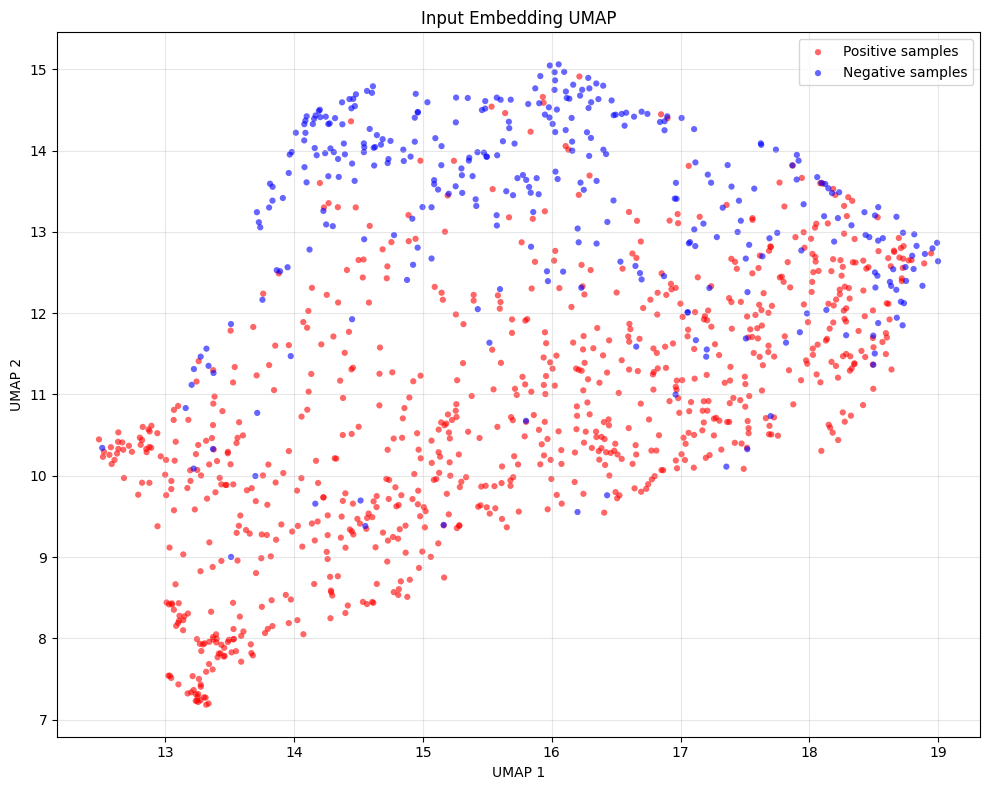

/home/songjiaxing/.conda/envs/PEL-PVP/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
fin

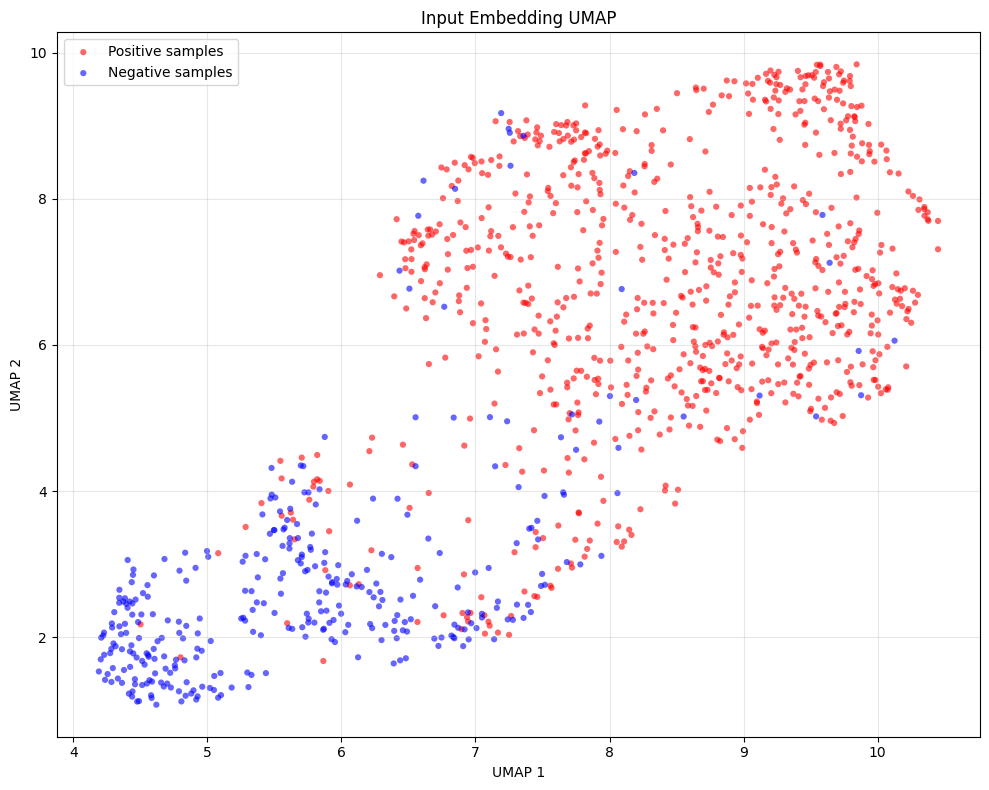

/home/songjiaxing/.conda/envs/PEL-PVP/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
fin

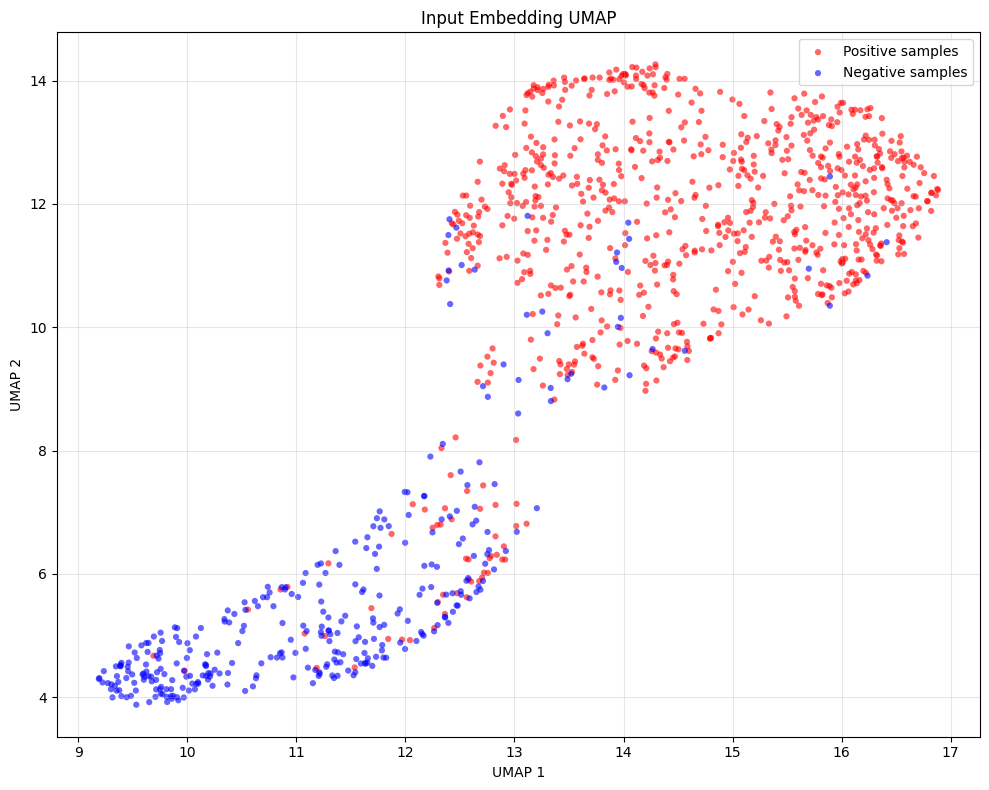

/home/songjiaxing/.conda/envs/PEL-PVP/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
fin

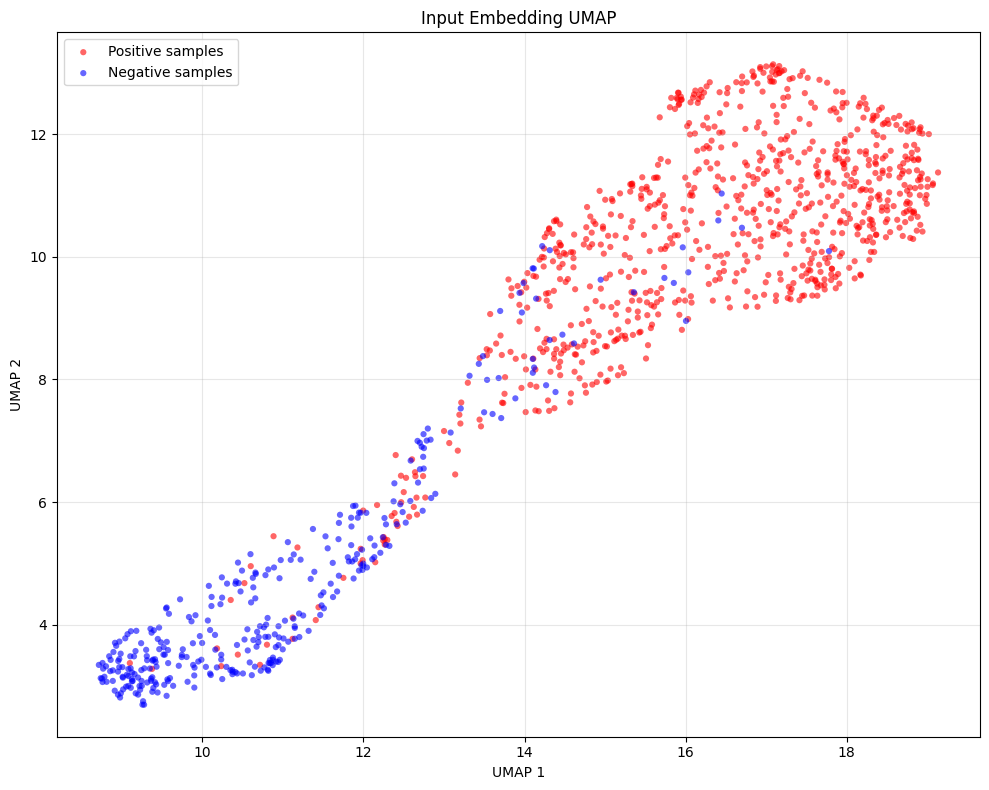

/home/songjiaxing/.conda/envs/PEL-PVP/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
fin

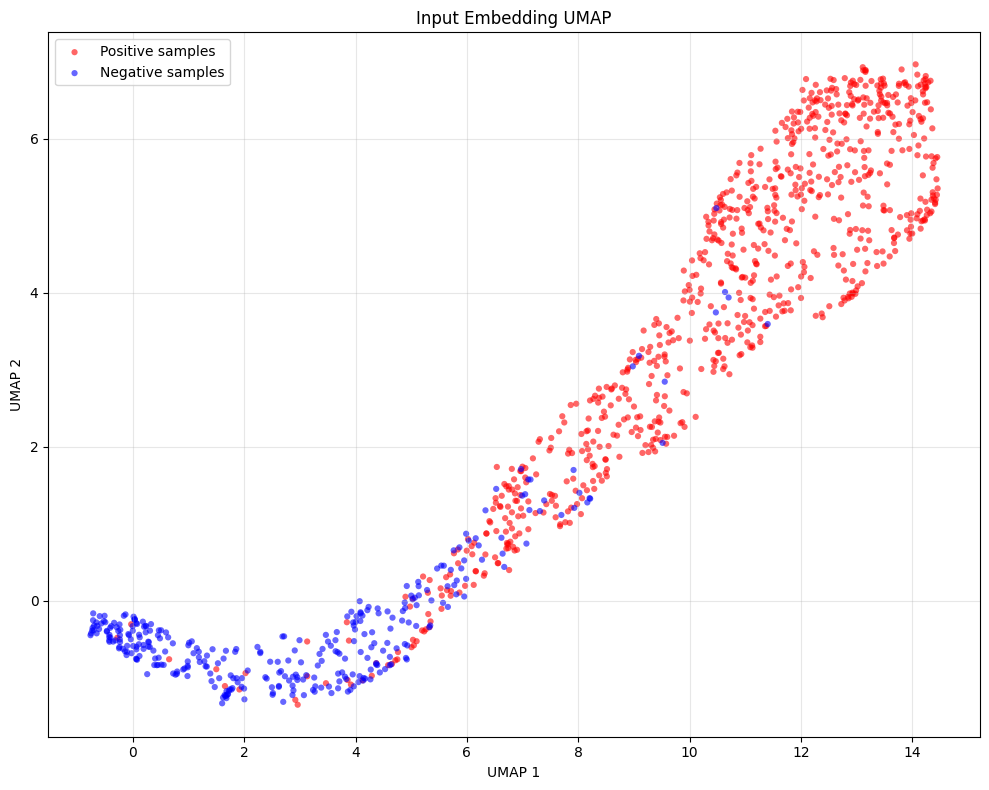

In [13]:
for i in range(0,5):
    # 原始输入
    features = processed_outputs[i]
    labels = all_labels
    sampled_features, sampled_labels = sample_features(features, labels)
    embedding_2d = umap_reduce(sampled_features)
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8))
    pos_mask = sampled_labels == 1
    neg_mask = sampled_labels == 0
    plt.scatter(embedding_2d[pos_mask, 0], embedding_2d[pos_mask, 1], c='red', s=20, alpha=0.6, label='Positive samples', edgecolors='none')
    plt.scatter(embedding_2d[neg_mask, 0], embedding_2d[neg_mask, 1], c='blue', s=20, alpha=0.6, label='Negative samples', edgecolors='none')
    plt.title('Input Embedding UMAP')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'/exp_data/sjx/star/experiments/zhongjianceng_umap/ceng_results/input_umap{i}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

/home/songjiaxing/.conda/envs/PEL-PVP/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei
fin

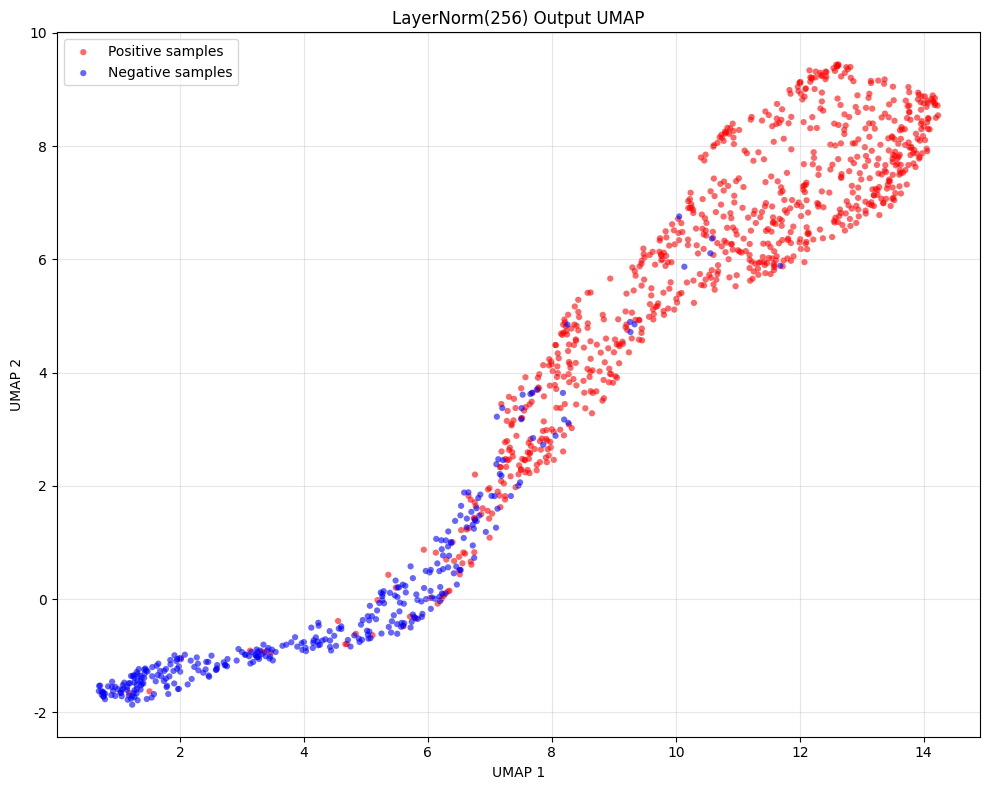

In [14]:
import torch
import torch.nn as nn

# 新的LayerNorm，参数是256维
layernorm_256 = nn.LayerNorm(256).to(device)
import numpy as np
import gc

features = reduced_outputs[4]  # [N, 256]
batch_size = 256
normed_features = []

for i in range(0, len(features), batch_size):
    batch = features[i:i+batch_size]
    batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)
    with torch.no_grad():
        normed = layernorm_256(batch_tensor).cpu().numpy()
    normed_features.append(normed)
    del batch_tensor, normed
    gc.collect()

normed_features = np.vstack(normed_features)
labels = all_labels
if len(normed_features) > 2000:
    np.random.seed(42)
    sample_indices = np.random.choice(len(normed_features), 2000, replace=False)
    sampled_features = normed_features[sample_indices]
    sampled_labels = labels[sample_indices]
else:
    sampled_features = normed_features
    sampled_labels = labels
import umap

reducer = umap.UMAP(n_neighbors=100, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(sampled_features)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
pos_mask = sampled_labels == 1
neg_mask = sampled_labels == 0
plt.scatter(embedding_2d[pos_mask, 0], embedding_2d[pos_mask, 1], c='red', s=20, alpha=0.6, label='Positive samples', edgecolors='none')
plt.scatter(embedding_2d[neg_mask, 0], embedding_2d[neg_mask, 1], c='blue', s=20, alpha=0.6, label='Negative samples', edgecolors='none')
plt.title('LayerNorm(256) Output UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/exp_data/sjx/star/experiments/zhongjianceng_umap/ceng_results/layernorm256_umap.pdf', dpi=300, bbox_inches='tight')
plt.show()